<a href="https://colab.research.google.com/github/sanaaria/Ann/blob/main/AnnHW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import SubsetRandomSampler

اتصال دیوایس

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ترین و تست را خواندن

In [110]:
trainset = torchvision.datasets.FashionMNIST("./data", download = True ,  transform = transforms.Compose([transforms.ToTensor()]))
testset = torchvision.datasets.FashionMNIST("./data" , download = True , train=False, transform = transforms.Compose([transforms.ToTensor()]))

# train_loader = torch.utils.data.DataLoader(trainset , batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(testset , batch_size=100, shuffle=True)
 

20 درصد ولید برمیداریم

بچ سایز را 20 تایی گرفته و لودر را تعریف میکنیم

In [111]:
valid_size=0.2
train_length=len(trainset)

indices=[i for i in range(train_length)]
np.random.shuffle(indices)

split=int(np.floor(valid_size*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]


train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

num_workers=0
batch_size=20
train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,num_workers=num_workers)

# This is for debugging
print(f"Training data size : {train_idx.__len__()}, Validation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

Training data size : 48000, Validation data size : 12000, Test data size : 60000


In [112]:
# checking our data
dataiter=iter(train_loader)
images,labels=next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

<class 'torch.Tensor'>
torch.Size([20, 1, 28, 28])
torch.Size([20])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.7333, 0.3255, 0.0000],
          ...,
          [0.1608, 0.8157, 0.7373,  ..., 0.9804, 0.9569, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.3961, 0.3529, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  

اسم گذاری روی لیبل ها میکنیم

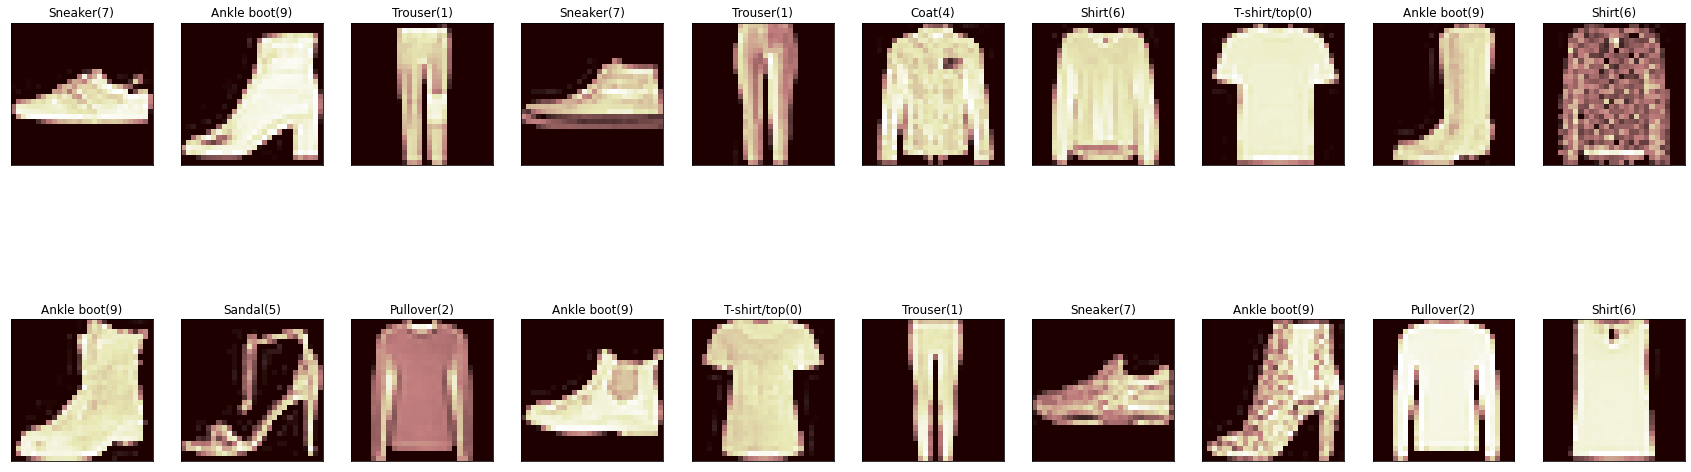

In [113]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]),cmap="pink")
    ax.set_title(f"{fashion_class[labels[i].item()]}({labels[i].item()})")

مدل را با 4 لایه تعریف میکنیم

In [49]:
MLP4 = nn.Sequential(nn.Linear(784, 250),
                           nn.ReLU(),
                           nn.Linear(250, 100),
                           nn.ReLU(),
                           nn.Linear(100, 50),
                           nn.ReLU(),
                           nn.Linear(50, 10),
                           nn.LogSoftmax(dim=1)
                           )


لاس و اپتیمایزر را تعریف میکنیم

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLP4.parameters(), lr = 0.0001)

تابعی برای ترین کردن مدل مینویسیم

In [53]:
def run_model(model, optimizer, epochs):
  train_losses, valid_losses = [], []

  for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
      images = images.view(images.shape[0], -1)
      
      optimizer.zero_grad()
      
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    else:
      valid_loss = 0
      accuracy = 0
      
      with torch.no_grad():
        model.eval()
        
        for images, labels in valid_loader:
          images = images.view(images.shape[0], -1)
          log_ps = model(images)
          valid_loss += criterion(log_ps, labels)
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(train_loader))
      valid_losses.append(valid_loss/len(valid_loader))
      
      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training loss: {:.3f}..".format(running_loss/len(train_loader)),
            "Test loss: {:.3f}..".format(valid_loss/len(valid_loader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
  return [train_losses, valid_losses]

In [54]:
results = run_model(MLP4 , optimizer ,10)

Epoch: 1/10.. Training loss: 0.485.. Test loss: 0.473.. Test Accuracy: 0.831
Epoch: 2/10.. Training loss: 0.433.. Test loss: 0.416.. Test Accuracy: 0.852
Epoch: 3/10.. Training loss: 0.405.. Test loss: 0.407.. Test Accuracy: 0.855
Epoch: 4/10.. Training loss: 0.385.. Test loss: 0.369.. Test Accuracy: 0.867
Epoch: 5/10.. Training loss: 0.368.. Test loss: 0.355.. Test Accuracy: 0.874
Epoch: 6/10.. Training loss: 0.356.. Test loss: 0.333.. Test Accuracy: 0.882
Epoch: 7/10.. Training loss: 0.342.. Test loss: 0.332.. Test Accuracy: 0.881
Epoch: 8/10.. Training loss: 0.330.. Test loss: 0.318.. Test Accuracy: 0.886
Epoch: 9/10.. Training loss: 0.320.. Test loss: 0.310.. Test Accuracy: 0.888
Epoch: 10/10.. Training loss: 0.311.. Test loss: 0.311.. Test Accuracy: 0.887


نمودار ترین لاس و ولید لاس را میکشیم تا اگر دچار اور فیت شدیم هم زود بفهمیم

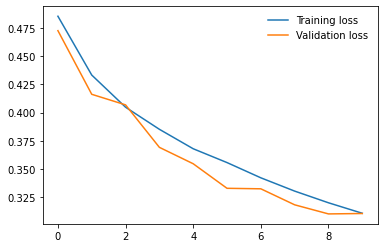

In [55]:
plt.plot(results[0], label = "Training loss")
plt.plot(results[1], label = "Validation loss")
plt.legend(frameon = False)

مدل را با سه لایه مینویسیم

In [56]:
MLP3 = nn.Sequential(nn.Linear(784, 250),
                           nn.ReLU(),
                           nn.Linear(250, 100),
                           nn.ReLU(),
                           nn.Linear(100, 10),
                           nn.LogSoftmax(dim=1)
                           )

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLP3.parameters(), lr = 0.0001)

In [67]:
results = run_model(MLP3 , optimizer ,10)

Epoch: 1/10.. Training loss: 0.703.. Test loss: 0.499.. Test Accuracy: 0.826
Epoch: 2/10.. Training loss: 0.458.. Test loss: 0.506.. Test Accuracy: 0.809
Epoch: 3/10.. Training loss: 0.414.. Test loss: 0.386.. Test Accuracy: 0.866
Epoch: 4/10.. Training loss: 0.387.. Test loss: 0.367.. Test Accuracy: 0.871
Epoch: 5/10.. Training loss: 0.367.. Test loss: 0.353.. Test Accuracy: 0.876
Epoch: 6/10.. Training loss: 0.350.. Test loss: 0.349.. Test Accuracy: 0.877
Epoch: 7/10.. Training loss: 0.337.. Test loss: 0.326.. Test Accuracy: 0.883
Epoch: 8/10.. Training loss: 0.324.. Test loss: 0.318.. Test Accuracy: 0.885
Epoch: 9/10.. Training loss: 0.313.. Test loss: 0.305.. Test Accuracy: 0.890
Epoch: 10/10.. Training loss: 0.304.. Test loss: 0.287.. Test Accuracy: 0.898


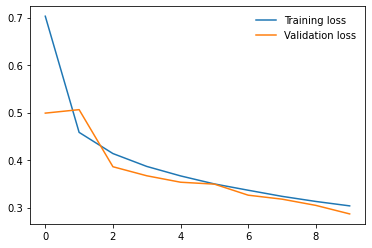

In [68]:
plt.plot(results[0], label = "Training loss")
plt.plot(results[1], label = "Validation loss")
plt.legend(frameon = False)

مدل را با دو لایه مینویسیم

In [73]:
MLP2 = nn.Sequential(nn.Linear(784, 250),
                           nn.ReLU(),
                           nn.Linear(250, 10),
                           nn.LogSoftmax(dim=1)
                           )

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLP2.parameters(), lr = 0.0001)

In [75]:
results = run_model(MLP2 , optimizer ,10)

Epoch: 1/10.. Training loss: 0.709.. Test loss: 0.515.. Test Accuracy: 0.827
Epoch: 2/10.. Training loss: 0.480.. Test loss: 0.469.. Test Accuracy: 0.836
Epoch: 3/10.. Training loss: 0.438.. Test loss: 0.415.. Test Accuracy: 0.857
Epoch: 4/10.. Training loss: 0.413.. Test loss: 0.402.. Test Accuracy: 0.858
Epoch: 5/10.. Training loss: 0.395.. Test loss: 0.382.. Test Accuracy: 0.866
Epoch: 6/10.. Training loss: 0.379.. Test loss: 0.365.. Test Accuracy: 0.872
Epoch: 7/10.. Training loss: 0.367.. Test loss: 0.355.. Test Accuracy: 0.874
Epoch: 8/10.. Training loss: 0.356.. Test loss: 0.342.. Test Accuracy: 0.880
Epoch: 9/10.. Training loss: 0.345.. Test loss: 0.332.. Test Accuracy: 0.883
Epoch: 10/10.. Training loss: 0.337.. Test loss: 0.325.. Test Accuracy: 0.885


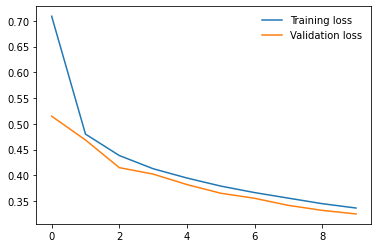

In [76]:
plt.plot(results[0], label = "Training loss")
plt.plot(results[1], label = "Validation loss")
plt.legend(frameon = False)

مدل را با 5 لایه بنویسیم

In [81]:
MLP5 = nn.Sequential(nn.Linear(784, 250),
                           nn.ReLU(),
                           nn.Linear(250, 100),
                           nn.ReLU(),
                           nn.Linear(100, 100),
                           nn.ReLU(),
                           nn.Linear(100, 50),
                           nn.ReLU(),
                           nn.Linear(50, 10),
                           nn.LogSoftmax(dim=1)
                           )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLP5.parameters(), lr = 0.0001)

In [82]:
results = run_model(MLP5 , optimizer ,10)

Epoch: 1/10.. Training loss: 0.817.. Test loss: 0.544.. Test Accuracy: 0.806
Epoch: 2/10.. Training loss: 0.504.. Test loss: 0.459.. Test Accuracy: 0.839
Epoch: 3/10.. Training loss: 0.451.. Test loss: 0.436.. Test Accuracy: 0.844
Epoch: 4/10.. Training loss: 0.420.. Test loss: 0.397.. Test Accuracy: 0.859
Epoch: 5/10.. Training loss: 0.397.. Test loss: 0.397.. Test Accuracy: 0.861
Epoch: 6/10.. Training loss: 0.377.. Test loss: 0.397.. Test Accuracy: 0.856
Epoch: 7/10.. Training loss: 0.359.. Test loss: 0.346.. Test Accuracy: 0.873
Epoch: 8/10.. Training loss: 0.346.. Test loss: 0.354.. Test Accuracy: 0.872
Epoch: 9/10.. Training loss: 0.332.. Test loss: 0.315.. Test Accuracy: 0.886
Epoch: 10/10.. Training loss: 0.321.. Test loss: 0.307.. Test Accuracy: 0.888


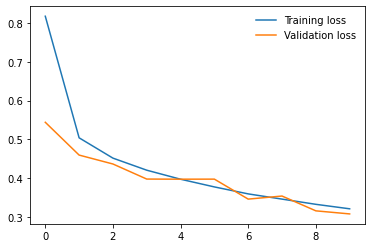

In [83]:
plt.plot(results[0], label = "Training loss")
plt.plot(results[1], label = "Validation loss")
plt.legend(frameon = False)

کمی اورفیت مشاهده میشود

در این بین بهترین مدل ،با سه لایه بود که در زیر میبینیم

In [88]:
MLP3 = nn.Sequential(nn.Linear(784, 250),
                           nn.ReLU(),
                           nn.Linear(250, 100),
                           nn.ReLU(),
                           nn.Linear(100, 10),
                           nn.LogSoftmax(dim=1)
                           )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLP3.parameters(), lr = 0.0001)
results = run_model(MLP3 , optimizer ,10)


Epoch: 1/10.. Training loss: 0.722.. Test loss: 0.500.. Test Accuracy: 0.824
Epoch: 2/10.. Training loss: 0.467.. Test loss: 0.433.. Test Accuracy: 0.850
Epoch: 3/10.. Training loss: 0.422.. Test loss: 0.410.. Test Accuracy: 0.856
Epoch: 4/10.. Training loss: 0.396.. Test loss: 0.380.. Test Accuracy: 0.866
Epoch: 5/10.. Training loss: 0.376.. Test loss: 0.367.. Test Accuracy: 0.871
Epoch: 6/10.. Training loss: 0.358.. Test loss: 0.343.. Test Accuracy: 0.878
Epoch: 7/10.. Training loss: 0.345.. Test loss: 0.328.. Test Accuracy: 0.883
Epoch: 8/10.. Training loss: 0.331.. Test loss: 0.315.. Test Accuracy: 0.887
Epoch: 9/10.. Training loss: 0.322.. Test loss: 0.316.. Test Accuracy: 0.886
Epoch: 10/10.. Training loss: 0.311.. Test loss: 0.307.. Test Accuracy: 0.889


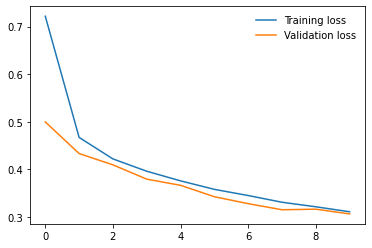

In [89]:
plt.plot(results[0], label = "Training loss")
plt.plot(results[1], label = "Validation loss")
plt.legend(frameon = False)

drop out را افزوده و نتایج را مشاهده مینماییم

In [94]:
MLP3 = nn.Sequential(nn.Linear(784, 250),
                           nn.ReLU(),
                           nn.Dropout(0.1),
                           nn.Linear(250, 100),
                           nn.ReLU(),
                           nn.Dropout(0.1),
                           nn.Linear(100, 10),
                           nn.LogSoftmax(dim=1)
                           )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLP3.parameters(), lr = 0.0001)
results = run_model(MLP3 , optimizer ,10)


Epoch: 1/10.. Training loss: 0.756.. Test loss: 0.497.. Test Accuracy: 0.827
Epoch: 2/10.. Training loss: 0.488.. Test loss: 0.431.. Test Accuracy: 0.848
Epoch: 3/10.. Training loss: 0.434.. Test loss: 0.390.. Test Accuracy: 0.862
Epoch: 4/10.. Training loss: 0.400.. Test loss: 0.367.. Test Accuracy: 0.869
Epoch: 5/10.. Training loss: 0.378.. Test loss: 0.355.. Test Accuracy: 0.872
Epoch: 6/10.. Training loss: 0.360.. Test loss: 0.337.. Test Accuracy: 0.878
Epoch: 7/10.. Training loss: 0.344.. Test loss: 0.318.. Test Accuracy: 0.885
Epoch: 8/10.. Training loss: 0.331.. Test loss: 0.301.. Test Accuracy: 0.891
Epoch: 9/10.. Training loss: 0.318.. Test loss: 0.299.. Test Accuracy: 0.891
Epoch: 10/10.. Training loss: 0.308.. Test loss: 0.283.. Test Accuracy: 0.897


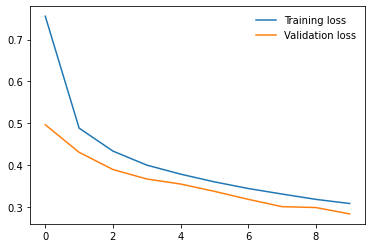

In [95]:
plt.plot(results[0], label = "Training loss")
plt.plot(results[1], label = "Validation loss")
plt.legend(frameon = False)

در مدل بدون دراپ اوت در اخر لاس ترین و تست بهم رسیدن در صورتی که قبل تر ازهم دور بودن و در مدل دراپ اوت دار اینا از هم دورن و مطمئنیم اپک کمی بیشتر هم باشه اورفیت نمیشه

early stoppingاستفاده از

In [97]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

In [98]:
def run_model_early_stop(model, optimizer, epochs):
  train_losses, valid_losses = [], []

  early_stopper = EarlyStopper(3, 10)
  for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
      images = images.view(images.shape[0], -1)
      
      optimizer.zero_grad()
      
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    else:
      valid_loss = 0
      accuracy = 0
      
      with torch.no_grad():
        model.eval()
        
        for images, labels in valid_loader:
          images = images.view(images.shape[0], -1)
          log_ps = model(images)
          valid_loss += criterion(log_ps, labels)
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(train_loader))
      valid_losses.append(valid_loss/len(valid_loader))
      if early_stopper.early_stop(valid_loss):
        print("Early stop has been triggered!")
        break

      
      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training loss: {:.3f}..".format(running_loss/len(train_loader)),
            "valid loss: {:.3f}..".format(valid_loss/len(valid_loader)),
            "valid Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
  return [train_losses, valid_losses]

In [105]:
early_results = run_model_early_stop(MLP3, optimizer, 20)

Epoch: 1/20.. Training loss: 0.309.. valid loss: 0.284.. valid Accuracy: 0.896
Epoch: 2/20.. Training loss: 0.301.. valid loss: 0.278.. valid Accuracy: 0.898
Epoch: 3/20.. Training loss: 0.292.. valid loss: 0.267.. valid Accuracy: 0.902
Epoch: 4/20.. Training loss: 0.283.. valid loss: 0.259.. valid Accuracy: 0.906
Epoch: 5/20.. Training loss: 0.275.. valid loss: 0.259.. valid Accuracy: 0.905
Epoch: 6/20.. Training loss: 0.268.. valid loss: 0.245.. valid Accuracy: 0.910
Epoch: 7/20.. Training loss: 0.264.. valid loss: 0.243.. valid Accuracy: 0.911
Epoch: 8/20.. Training loss: 0.256.. valid loss: 0.236.. valid Accuracy: 0.914
Epoch: 9/20.. Training loss: 0.250.. valid loss: 0.227.. valid Accuracy: 0.916
Epoch: 10/20.. Training loss: 0.246.. valid loss: 0.222.. valid Accuracy: 0.919
Epoch: 11/20.. Training loss: 0.240.. valid loss: 0.217.. valid Accuracy: 0.922
Epoch: 12/20.. Training loss: 0.232.. valid loss: 0.211.. valid Accuracy: 0.923
Epoch: 13/20.. Training loss: 0.231.. valid loss:

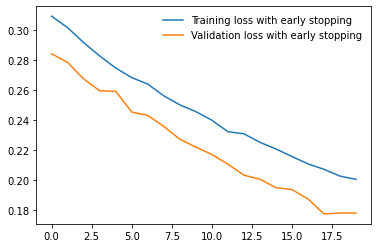

In [106]:
plt.plot(early_results[0], label = "Training loss with early stopping")
plt.plot(early_results[1], label = "Validation loss with early stopping")
plt.legend(frameon = False)

نرمال‌سازی دسته‌ای: نرمال‌سازی دسته‌ای تکنیکی برای آموزش شبکه‌های عصبی بسیار عمیق است که ورودی‌های یک لایه را برای هر مینی بچ استاندارد می‌کند. این امر باعث تثبیت فرآیند یادگیری و کاهش چشمگیر تعداد دوره های آموزشی مورد نیاز برای آموزش شبکه های عمیق می شود.

In [116]:
MLP_batch = nn.Sequential(nn.Linear(784, 250),
                           nn.ReLU(),
                           nn.Dropout(0.1),
                           nn.BatchNorm1d(250),
                           nn.Linear(250, 100),
                           nn.ReLU(),
                           nn.Dropout(0.1),
                           nn.BatchNorm1d(100),
                           nn.Linear(100, 10),
                           nn.LogSoftmax(dim=1))
batch_optimizer = optim.Adam(MLP_batch.parameters(), lr= 0.00001)
batch_results = run_model(MLP_batch, batch_optimizer, 20)

Epoch: 1/20.. Training loss: 1.148.. Test loss: 0.760.. Test Accuracy: 0.792
Epoch: 2/20.. Training loss: 0.743.. Test loss: 0.587.. Test Accuracy: 0.829
Epoch: 3/20.. Training loss: 0.624.. Test loss: 0.503.. Test Accuracy: 0.845
Epoch: 4/20.. Training loss: 0.559.. Test loss: 0.461.. Test Accuracy: 0.853
Epoch: 5/20.. Training loss: 0.517.. Test loss: 0.429.. Test Accuracy: 0.859
Epoch: 6/20.. Training loss: 0.485.. Test loss: 0.404.. Test Accuracy: 0.866
Epoch: 7/20.. Training loss: 0.466.. Test loss: 0.386.. Test Accuracy: 0.871
Epoch: 8/20.. Training loss: 0.449.. Test loss: 0.371.. Test Accuracy: 0.874
Epoch: 9/20.. Training loss: 0.431.. Test loss: 0.360.. Test Accuracy: 0.877
Epoch: 10/20.. Training loss: 0.418.. Test loss: 0.349.. Test Accuracy: 0.880
Epoch: 11/20.. Training loss: 0.410.. Test loss: 0.342.. Test Accuracy: 0.881
Epoch: 12/20.. Training loss: 0.397.. Test loss: 0.331.. Test Accuracy: 0.885
Epoch: 13/20.. Training loss: 0.390.. Test loss: 0.322.. Test Accuracy: 0

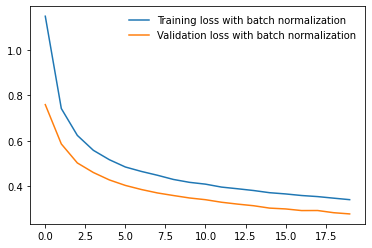

In [117]:
plt.plot(batch_results[0], label = "Training loss with batch normalization")
plt.plot(batch_results[1], label = "Validation loss with batch normalization")
plt.legend(frameon = False)

روی داده ی تست هم دقت را محاسبه میکنیم

In [118]:
def run_model_testset(model, optimizer, epochs):
  train_losses, test_losses = [], []

  for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
      images = images.view(images.shape[0], -1)
      
      optimizer.zero_grad()
      
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    else:
      test_loss = 0
      accuracy = 0
      
      with torch.no_grad():
        model.eval()
        
        for images, labels in test_loader:
          images = images.view(images.shape[0], -1)
          log_ps = model(images)
          test_loss += criterion(log_ps, labels)
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(train_loader))
      test_losses.append(test_loss/len(test_loader))
      
      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training loss: {:.3f}..".format(running_loss/len(train_loader)),
            "Test loss: {:.3f}..".format(test_loss/len(test_loader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
  return [train_losses, test_losses]

In [119]:
batch_results = run_model_testset(MLP_batch, batch_optimizer, 20)

Epoch: 1/20.. Training loss: 0.339.. Test loss: 0.287.. Test Accuracy: 0.898
Epoch: 2/20.. Training loss: 0.333.. Test loss: 0.284.. Test Accuracy: 0.900
Epoch: 3/20.. Training loss: 0.330.. Test loss: 0.279.. Test Accuracy: 0.901
Epoch: 4/20.. Training loss: 0.324.. Test loss: 0.276.. Test Accuracy: 0.902
Epoch: 5/20.. Training loss: 0.318.. Test loss: 0.271.. Test Accuracy: 0.903
Epoch: 6/20.. Training loss: 0.315.. Test loss: 0.269.. Test Accuracy: 0.904
Epoch: 7/20.. Training loss: 0.313.. Test loss: 0.265.. Test Accuracy: 0.905
Epoch: 8/20.. Training loss: 0.308.. Test loss: 0.263.. Test Accuracy: 0.907
Epoch: 9/20.. Training loss: 0.304.. Test loss: 0.260.. Test Accuracy: 0.907
Epoch: 10/20.. Training loss: 0.304.. Test loss: 0.257.. Test Accuracy: 0.908
Epoch: 11/20.. Training loss: 0.297.. Test loss: 0.255.. Test Accuracy: 0.909
Epoch: 12/20.. Training loss: 0.297.. Test loss: 0.251.. Test Accuracy: 0.911
Epoch: 13/20.. Training loss: 0.291.. Test loss: 0.249.. Test Accuracy: 0

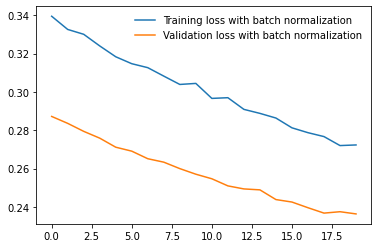

In [120]:
plt.plot(batch_results[0], label = "Training loss with batch normalization")
plt.plot(batch_results[1], label = "Validation loss with batch normalization")
plt.legend(frameon = False)